# IMDB Example
This Example was adapted from Deep Learning with Python Chapter 4 Chollet, F. (2021). Deep Learning with Python (2nd ed.). Greenwich, CT, USA: Manning Publications Co.

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

### This is an example of a binary classification problem using the prepackaged IMDB dateset from the Keras library.  The IMDB dataset has 50,000 training and test reviews form IMDB.  We will use a deep neural net to classify the reviews as positive or negative.

In [ ]:
from keras.datasets import imdb
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf

np.random.seed(1)

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)
# When we import the data we only select the 10,000 most common words in the reviews.
# We do this because if we trained on the least common words we would be training
# on words that may only appear in a handful or less of samples. 

In [ ]:
# The train_labels and test_labels consist of 0 and 1, representing negative and positve reviews, respectively.
print(train_labels[0:10])

In [ ]:
# There are 25,000 training examples
print(train_data.shape)

In [ ]:
# The train_data and test_data are already converted into word indices.  
# Each number below represents a word from the word index.  
# The word index is 10,000 digits: 0 to 9999
print(train_data[0])

In [ ]:
# Let's get and print the word index
wi = imdb.get_word_index()
print(wi)

In [ ]:
# We can sort the items in the word index and return the 50 most common words
import operator
sorted(wi.items(), key=operator.itemgetter(1))[:50]

In [ ]:
# We can convert the word index back to a written review:
reverse_word_index = dict(
    [(value, key) for (key, value) in wi.items()])
decoded_review = ' '.join(
    [reverse_word_index.get(i-3, '?') for i in train_data[10000]])
print(decoded_review)

In [ ]:
# Split our training examples into training/validation subsets
train_data, valid_data, train_labels, valid_labels = train_test_split(
    train_data, train_labels, test_size=0.2, shuffle= True)

### We cannot add a single vector to a neural network. The data needs to be converted to a tensor.
This will create sparse tensors that are 25000-by-10000. 25000 is the number of samples and 10000 is the number of unique words. The tensor will have all zeros except for ones in indices where a given word is in the review. Rather than storing a bunch of zero values, we will only store the locations and values of the non-zero entries of the tensor -- much more memory efficient!

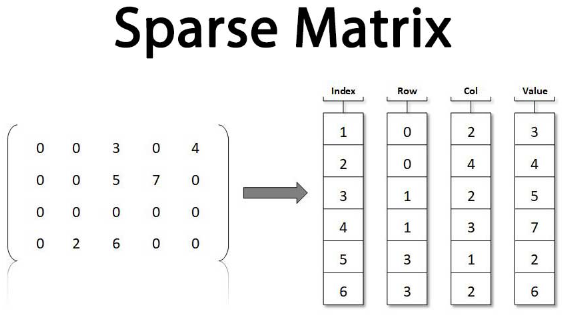

In [ ]:
def vectorize_sequences(sequences, dimension=10000):
    word_matrix = tf.sparse.SparseTensor(
        # The non-zero locations in each row correspond to the word indices that are found in the document
        indices=[[row_idx, word_idx] for row_idx, word_indices in enumerate(sequences) for word_idx in set(word_indices)],
        # Use "1" as the value of each non-zero index (indicating the word is used in the document)
        values=[1 for row_idx, word_indices in enumerate(sequences) for word_idx in set(word_indices)],
        # The overall tensor shape
        dense_shape=[len(sequences), dimension]
    )
    # Optimize by ordering the non-zero indices in ascending row-major order
    word_matrix = tf.sparse.reorder(word_matrix)
    return word_matrix

In [ ]:

# Convert the train/validation/test datasets into sparse tensors
x_train = vectorize_sequences(train_data)
x_valid = vectorize_sequences(valid_data)
x_test = vectorize_sequences(test_data)

In [ ]:
# View the train shape and dimensions
print(x_train.shape)
print(tf.rank(x_train))

In [ ]:
# Convert the y targets to float32
y_train = np.asarray(train_labels).astype('float32')
y_valid = np.asarray(valid_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

In [ ]:
# Import the keras libraries
from keras import models, layers
from keras.layers import Flatten, Dense

In [ ]:
# Build the model architecture.  Input shape must equal the number of vectors or (unique words).
# Add one hidden layer with 16 units.  Keep the activation function as 'relu'
# Since we have a binary classification, the output activation function will be 'sigmoid'
# We will keep with the 'rmsprop' optomizer function, loss = 'binary_crossentropy', and metrics = 'accuracy'
model = models.Sequential()
model.add(layers.Dense(16, activation = 'relu', input_dim = (10000)))
model.add(layers.Dense(16, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))
model.compile(optimizer='rmsprop',
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])

In [ ]:
# Fit the model to the training data. 
history = model.fit(x_train,
                   y_train,
                   epochs = 20,
                   batch_size = 512,
                   validation_data=(x_valid, y_valid))

In [ ]:
import pandas as pd
# Use this bit of code to view the History output.
hist = pd.DataFrame(history.history)
print(hist.tail())

In [ ]:
# Let's plot the Loss vs Epochs and Accuracy vs Epochs
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(history_dict['accuracy']) + 1)

In [ ]:
plt.plot(epochs, loss_values, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss_values, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
plt.plot(epochs, acc_values, 'bo', label = 'Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# It looks like the Validation Loss increases after about 3 Epochs and the validation accuracy decreases after about 
# 5 epochs.  Lets refit the data but only use 3 epochs and then apply the model on the test data
model = models.Sequential()
model.add(layers.Dense(16, activation = 'relu', input_shape = (10000,)))
model.add(layers.Dense(16, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))
model.compile(optimizer='adam',
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])

model.fit(x_train,
          y_train,
          epochs = 3,
          batch_size = 512)
results = model.evaluate(x_test, y_test)
print(model.metrics_names)
print(results)

In [ ]:
# Apply to model to the test data and view the results
model.predict(x_test)

In [ ]:
# View the predicted results rounded to a 1 or 0
ans = model.predict(x_test)
np.rint(ans)

In [ ]:
# Let's use our decode_review code from above to see if our predicted 
# classes make sense.
reverse_word_index = dict(
    [(value, key) for (key, value) in wi.items()])
decoded_review = ' '.join(
    [reverse_word_index.get(i-3, '?') for i in test_data[0]])
print(decoded_review)

In [ ]:
# Looks like the first test_data review is negative which matches our prediction.
np.rint(ans)[0]